In [422]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [423]:
%autoreload 2

In [424]:
import os
import numpy as np
import torch
from pathlib import Path

print(torch.__version__)

1.9.0+cu111


In [425]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [426]:
torch.cuda.empty_cache()

In [427]:
import sys

if os.path.join(os.getcwd(), "detr/") not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "detr/"))
    
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/ammar/projects/.venv/lib/python3.6/site-packages', '/home/ammar/projects/.venv/lib/python3.6/site-packages/IPython/extensions', '/home/ammar/.ipython', '/home/ammar/projects/construction/train_orig/detr/']


In [662]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
a = {'lr': 0.0001, 'lr_backbone': 1e-05, 'batch_size': 1, 'weight_decay': 0.0001, 'epochs': 300, 'lr_drop': 200, 'clip_max_norm': 0.1, 'frozen_weights': None, 'backbone': 'resnet50', 'dilation': False, 'position_embedding': 'sine', 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 20, 'pre_norm': False, 'masks': False, 'aux_loss': True, 'set_cost_class': 1, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coef': 0.1, 'dataset_file': 'construction', 'data_path': None, 'data_panoptic_path': None, 'remove_difficult': False, 'output_dir': '', 'device': 'cuda', 'resume': '', 'thresh': 0.5}

a['resume'] = '/home/ammar/projects/construction/data/output_all_150_19_09_2022/checkpoint.pth'

args = Args(**a)

In [663]:
import torch
from  models import build_model

device = torch.device(args.device)

model, _, postprocessors = build_model(args)
model.eval()

if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

model.to(device)

print("Model Loaded")

Model Loaded


In [664]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import math
from pathlib import Path
from datasets.construction import make_construction_transforms
from datasets.categories_meta import id2cat
import time


# def box_cxcywh_to_xyxy(x):
#     x_c, y_c, w, h = x.unbind(1)
#     b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
#          (x_c + 0.5 * w), (y_c + 0.5 * h)]
#     return torch.stack(b, dim=1)

# def rescale_bboxes(out_bbox, size):
#     img_w, img_h = size
#     b = box_cxcywh_to_xyxy(out_bbox)
#     b = b * torch.tensor([img_w, img_h,
#                           img_w, img_h
#                           ], dtype=torch.float32)

def get_prediction(pth, threshold):
    
    impath = Path(pth)
    
    imo = Image.open(impath)
    
    fixed_height = 600
    height_percent = (fixed_height / float(imo.size[1]))
    width_size = int((float(imo.size[0]) * float(height_percent)))

    imo = imo.resize((width_size, fixed_height))
    iw, ih = imo.size

    transform = make_construction_transforms("val")

    dummy_target = {
        "size": torch.as_tensor([int(ih), int(iw)]),
        "orig_size": torch.as_tensor([int(ih), int(iw)])
    }

    image, targets = transform(imo, dummy_target)
    image = image.unsqueeze(0)
    image = image.to(device)

    # conv_features, enc_attn_weights, dec_attn_weights = [], [], []
    # hooks = [
    #     model.backbone[-2].register_forward_hook(
    #                 lambda self, input, output: conv_features.append(output)

    #     ),
    #     model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
    #                 lambda self, input, output: enc_attn_weights.append(output[1])

    #     ),
    #     model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
    #                 lambda self, input, output: dec_attn_weights.append(output[1])

    #     ),
    # ]


    start_t = time.perf_counter()
    outputs = model(image)
    end_t = time.perf_counter()

    outputs["pred_logits"] = outputs["pred_logits"].cpu()
    outputs["pred_boxes"] = outputs["pred_boxes"].cpu()

    scores = outputs["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
    # threshold the confidence
    keep = scores > threshold

    scores, pred_logits, pred_boxes = scores[keep], outputs["pred_logits"][keep], outputs["pred_boxes"][keep].cpu()

    # for hook in hooks:
    #     hook.remove()

    # conv_features = conv_features[0]
    # enc_attn_weights = enc_attn_weights[0]
    # dec_attn_weights = dec_attn_weights[0].cpu()

    # conv_features['0'].tensors.shape

    imn = imo.copy()
    drw = ImageDraw.Draw(imn)
    font = ImageFont.load_default() # ImageFont.truetype("arial")

    for score, logits, box in zip(scores, pred_logits, pred_boxes):
        cls = logits.argmax()
        if cls < 1:
            continue
        label = f'{id2cat[cls.item()]} ({score:.2f})'
        box = box * torch.Tensor([iw, ih, iw, ih])

        x, y, w, h = box
        # x0, x1 = x-w//2, x+w//2
        # y0, y1 = y-h//2, y+h//2

        rbbox = torch.tensor([(x - 0.5 * w), (y - 0.5 * h), (x + 0.5 * w), (y + 0.5 * h)]).cpu()

        rbbox[0::2].clamp_(min=0, max=torch.tensor(iw))
        rbbox[1::2].clamp_(min=0, max=torch.tensor(ih))

        print(label, rbbox)

        drw.rectangle(list(rbbox), outline='red', width=3)
        # drw.text((rbbox[0]+4, rbbox[1]+2), label, fill='white')

        # get text size
        text_size = font.getsize(label)
        # set button size + 10px margins
        label_size = (text_size[0]+6, text_size[1]+6)
        # create image with correct size and black background
        label_img = Image.new('RGBA', label_size, "green")
        # put text on button with 10px margins
        label_draw = ImageDraw.Draw(label_img)
        label_draw.text((3, 3), label, font=font, fill='white')

        # put button on source image in position (0, 0)
        imn.paste(label_img, (rbbox[0]+2, rbbox[1]+2))
    
    return imn

In [665]:
test_images = [
    'aac_blocks_2196.jpg',
    'aac_blocks_2201.jpg',
    'adhesives_1160.jpg', 
    'ahus_8881.jpg', 
    'aluminium_frames_for_false_ceiling_9505.jpg', 
    'chiller_1119.jpg', 
    'concrete_mixer_machine_7139.jpg',
    'concrete_pump_8290.jpg',
    'concrete_pump_8296.jpg',
    'control_panel_2444.jpg',
    'control_panel_2463.jpg',
    'cu_piping_10001.jpg',
    'cu_piping_10002.jpg',
    'distribution_transformer_7418.jpg',
    'distribution_transformer_7419.jpg',
    'distribution_transformer_7422.jpg',
    'emulsion_paint_3549.jpg',
    'enamel_paint_9171.jpg',
    'fine_aggregate_5220.jpg',
    'fine_aggregate_5247.jpg',
    'fire_buckets_7826.jpg',
    'fire_buckets_7827.jpg',
    'fire_extinguishers_9279.jpg',
    'fire_extinguishers_9291.jpg',
    'glass_wool_1005.jpg',
    'grader_8467.jpg',
    'hoist_2990.jpg',
    'hollow_concrete_blocks_5724.jpg',
    'hot_mix_plant_9548.jpg',
    'hydra_crane_8.jpg',
    'hydra_crane_10.jpg',
    'hydra_crane_14.jpg',
    'interlocked_switched_socket_8912.jpg',
    'junction_box_5765.jpg',
    'lime_5925.jpg',
    'marble_5827.jpg',
    'pipe_fittings_5916.jpg',
    'rcc_hume_pipes_2749.jpg',
    'rcc_hume_pipes_2759.jpg',
    'refrigerant_gas_8372.jpg',
    'river_sand_7246.jpg',
    'rmc_batching_plant_5155.jpg',
    'rmu_units_1053.jpg',
    'sanitary_fixtures_1655.jpg',
    'sanitary_fixtures_1668.jpg',
    'skid_steer_loader_8993.jpg',
    'smoke_detectors_4627.jpg',
    'split_units_108.jpg',
    'structural_steel_channel_1269.jpg',
    'switch_boards_and_switches_4204.jpg',
    'texture_paint_9230.jpg',
    'texture_paint_9255.jpg',
    'threaded_rod_3602.jpg',
    'transit_mixer_889.jpg',
    'transit_mixer_899.jpg',
    'vcb_panel_4700.jpg',
    'vitrified_tiles_6467.jpg',
    'vitrified_tiles_6471.jpg',
    'vrf_units_2729.jpg',
    'water_tank_6831.jpg',
    'water_tank_6834.jpg',
    'wheel_loader_647.jpg',
    'dump_truck_tipper_truck_802.jpg'
]

window (0.88) tensor([256.6448,  77.4119, 453.2016, 338.4235])
misc (0.91) tensor([266.4198, 289.3077, 613.3303, 453.5582])
building (0.91) tensor([512.6815, 218.0508, 670.5177, 329.4126])
window (0.92) tensor([261.8451,  84.4669, 447.5303, 325.9943])
texture_paint (0.84) tensor([1.3275e-02, 0.0000e+00, 7.2100e+02, 5.9930e+02])
wall (0.96) tensor([  0.0000,   0.0000, 720.9757, 599.8345])
structural (0.83) tensor([550.1665, 280.2548, 721.0000, 379.5241])
plant (0.97) tensor([366.0787,   0.7560, 721.0000, 464.9174])
sky (0.87) tensor([528.1906,  36.8543, 718.4059, 205.2607])


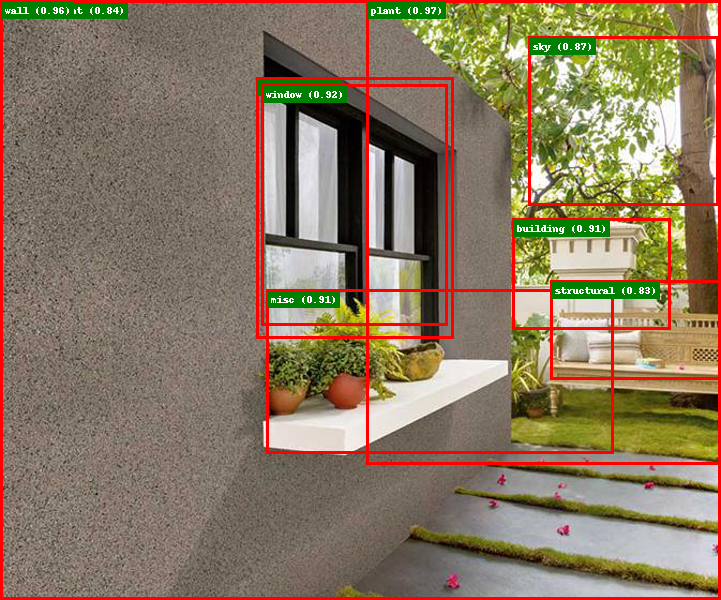

In [707]:
# for i in test_images:
#     pred_img = get_prediction(f'../../construction/data/images/{i}', 0.79)
#     pred_img.save(f'predictions/{i}')
#     pred_img

i = 'texture_paint_9255.jpg'
pred_img = get_prediction(f'../../construction/data/images/{i}', 0.80)
pred_img.save(f'predictions/{i}')
pred_img

# get_prediction('../../construction/data/test/test10.jpg', 0.50)

In [667]:
torch.cuda.empty_cache()

In [ ]:
tocheck = ['dump_truck_tipper_truck_802.jpg']

In [413]:
import cv2
from matplotlib import pyplot as plt

import albumentations as A


BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min), (x_min + text_width, y_min  + int(1.3 * text_height)), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min + int( text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    
    cv2.imwrite('ricap.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, thickness=5):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, thickness=thickness)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)

In [414]:
import os
import json
import random
import numpy as np

# random.seed(10)

# def convert(o):
#     if isinstance(o, np.generic): return o.item()  
#     raise TypeError

# Read Files
ROOT_DIR = '../data'

COCO_FILE = 'coco.json'

with open(os.path.join(ROOT_DIR, COCO_FILE), "r") as coco_file:
    coco_data = json.load(coco_file)

In [415]:
total_images = len(coco_data['images'])

val_images = list(random.sample(list(range(1, total_images+1)), 4))

bbs = {i: [] for i in val_images}
cats = {i: [] for i in val_images}
imgs = {i: [] for i in val_images}

for ann in coco_data['annotations']:
    if ann['image_id'] in val_images:
        bbs[ann['image_id']].append(ann['bbox'])
        cats[ann['image_id']].append(ann['category_id'])

for img in coco_data['images']:
    if img['id'] in val_images:
        imgs[img['id']] = img['file_name']

In [416]:
trans_imgs = []
trans_bbs = torch.tensor([])
trans_cats = []

transform = A.Compose(
    [A.SmallestMaxSize(max_size=400), A.RandomCrop(width=300, height=300)],
    bbox_params=A.BboxParams(format='coco', label_fields=["category_ids"], min_visibility=0.5),
)

for i in range(4):
    image = cv2.imread(os.path.join(ROOT_DIR, 'images', imgs[val_images[i]]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    print(image.shape)
    print(bbs[val_images[i]])

    transformed = transform(image=image, bboxes=bbs[val_images[i]], category_ids=cats[val_images[i]])
    
    trans_imgs.append(transformed)
    bb_tensor = torch.tensor(transformed['bboxes'])
    
    if len(bb_tensor) > 0:
    
        if i == 1:
            bb_tensor[:, 1]+=300
        if i == 2:
            bb_tensor[:, 0]+=300
        if i == 3:
            bb_tensor[:, 0]+=300
            bb_tensor[:, 1]+=300

        trans_bbs = torch.cat([trans_bbs, bb_tensor], dim=0)
        trans_cats += transformed['category_ids']

(1080, 1920, 3)
[[1480.8, 717.27, 149.47, 52.39], [1272.78, 1033.16, 83.21, 46.84], [238.81, 520.03, 1400.71, 482.31], [404.0, 400.0, 340.0, 315.0], [244.0, 377.0, 161.0, 166.0], [167.0, 267.0, 1588.0, 273.0], [0.0, 0.0, 1920.0, 1080.0], [200.0, 0.0, 1601.0, 400.0]]
(750, 750, 3)
[[15.08, 202.42, 724.31, 457.68], [0.0, 0.0, 750.0, 750.0]]
(375, 600, 3)
[[372.23, 216.13, 227.77, 108.85], [276.72, 166.53, 38.45, 136.39], [494.2, 180.0, 14.45, 46.72], [329.0, 229.0, 263.0, 95.0], [319.0, 304.0, 151.0, 71.0], [211.0, 0.0, 389.0, 343.0], [0.0, 0.0, 600.0, 375.0]]
(601, 344, 3)
[[1.98, 2.38, 338.46, 514.02], [58.0, 218.0, 246.0, 383.0], [0.0, 486.0, 152.0, 115.0], [0.0, 0.0, 344.0, 601.0]]


In [417]:
combined_img = torch.cat([
    torch.cat([
        torch.tensor(trans_imgs[0]['image']), 
        torch.tensor(trans_imgs[1]['image'])
    ], dim=0),
    torch.cat([
        torch.tensor(trans_imgs[2]['image']), 
        torch.tensor(trans_imgs[3]['image'])
    ], dim=0)
], dim=1)

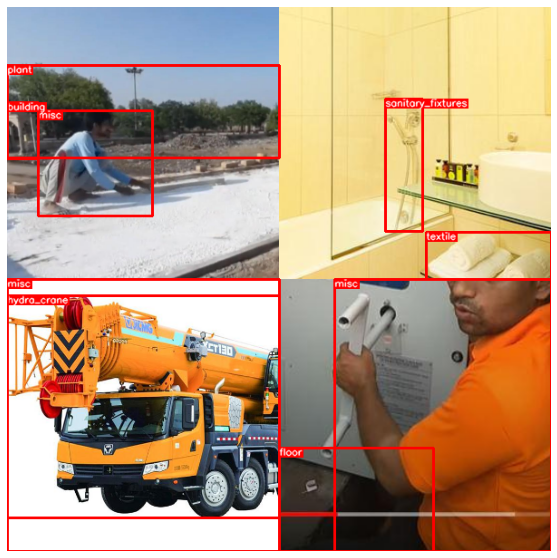

In [418]:
visualize(
    combined_img.detach().numpy(),
    trans_bbs,
    trans_cats,
    id2cat,
    thickness=2
)

In [419]:
!zip -r predictions.zip predictions

updating: predictions/ (stored 0%)
updating: predictions/vitrified_tiles_6471.jpg (deflated 6%)
  adding: predictions/.ipynb_checkpoints/ (stored 0%)
  adding: predictions/.ipynb_checkpoints/vitrified_tiles_6471-checkpoint.jpg (deflated 6%)


In [671]:
!pip install metaphone

In [676]:
from metaphone import doublemetaphone

doublemetaphone("STERLING AND WILSON")

('STRLNKNTLSN', '')

In [706]:
torch.tensor([]).shape[0] > 0

False